In [1]:
%matplotlib inline

import tensorflow as tf
import keras as k
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
from keras.datasets import mnist
from keras import layers
from keras.models import Model, load_model
from keras import optimizers
from keras import losses
from keras import callbacks
from keras.utils.np_utils import to_categorical
from keras import regularizers
import os.path as path
import os
import pickle
from keras import backend as K

jtplot.style(grid=False, ticks=True)

Using TensorFlow backend.


In [2]:
def show_test(model, validation_data):
    labels = np.argmax(model.predict(validation_data[0]), axis=1)
    ground_truth = np.argmax(validation_data[1], axis=1)
    accuracy = np.sum(labels == ground_truth)/labels.size
    num_errors = min(np.sum(labels != ground_truth), 20)
    errors = np.random.choice(np.nonzero(labels != ground_truth)[0], num_errors, replace=False)
    correct = np.random.choice(
        np.nonzero(labels == ground_truth)[0], 60 - num_errors, replace=False)
    stimuli = np.hstack((errors, correct))
    np.random.shuffle(stimuli)
    plt.style.use('grayscale')
    num_columns = 10
    num_rows = 6
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 3 * num_rows))
    for idx, ax in zip(stimuli, axes.ravel()):
        if idx in errors:
            c = 'r'
        else:
            c = 'k'
        ax.matshow(validation_data[0][idx, :, :, 0])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title('Prediction: '+str(labels[idx])+
                     ' \n Truth: '+str(ground_truth[idx]), color=c)
    plt.suptitle("Model accuracy: "+str(accuracy*100)+" %")
    plt.show()
    jtplot.style(grid=False, ticks=True)

In [3]:
help(mnist.load_data)

(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = to_categorical(l_train), to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

Help on function load_data in module keras.datasets.mnist:

load_data(path='mnist.npz')
    Loads the MNIST dataset.
    
    # Arguments
        path: path where to cache the dataset locally
            (relative to ~/.keras/datasets).
    
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.



In [4]:
def enhance_mnist(i_train, l_train, transf = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
    i_enhanced = []
    l_enhanced = []
    for i in range(i_train.shape[0]):
        img = i_train[i, :, :, :]
        label = l_train[i, :]
        i_enhanced.append(img)
        l_enhanced.append(label)
        for shift in transf:
            x = np.pad(img, ((abs(shift[0]), abs(shift[0])),
                         (abs(shift[1]), abs(shift[1])), (0, 0)), 'constant')
            x = np.roll(x, shift, (0, 1))
            x = x[abs(shift[0]):(x.shape[0]-abs(shift[0])),
                  abs(shift[1]):(x.shape[1]-abs(shift[1])), :]
            i_enhanced.append(x)
            l_enhanced.append(label)
    i_enhanced = np.array(i_enhanced)
    l_enhanced = np.array(l_enhanced)
    perm_idx = np.random.permutation(i_enhanced.shape[0])
    return i_enhanced[perm_idx, :, :, :], l_enhanced[perm_idx, :]

In [5]:
if not path.isdir('data'):
    os.mkdir('data')

if path.isfile(path.join('data', 'training_hist.pkl')):
    with open(path.join('data', 'training_hist.pkl'), 'rb') as f:
        history = pickle.load(f)

In [6]:
minibatch_size = 10
n_epochs = 60
learn_rate = 0.1
history = {}
tb_params = {
    'write_images': True, 'histogram_freq': 5, 
    'write_grads': True, 'write_graph': False
            }
activation_fcn = 'sigmoid'

In [ ]:
img = layers.Input(shape=(28, 28, 1,), name='images')
x = layers.Flatten()(img)
x = layers.Dense(100, activation=activation_fcn, name='hidden')(x)
out = layers.Dense(10, activation='softmax', name='output')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'fully_connected'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Fully Connected'] = h.history
history['Fully Connected']['epoch'] = h.epoch
model.save(path.join('data', 'fully_connected.h5'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 17s 337us/step - loss: 0.4008 - acc: 0.8846 - val_loss: 0.2487 - val_acc: 0.9285
Epoch 2/60
 5970/50000 [==>...........................] - ETA: 13s - loss: 0.2430 - acc: 0.9290

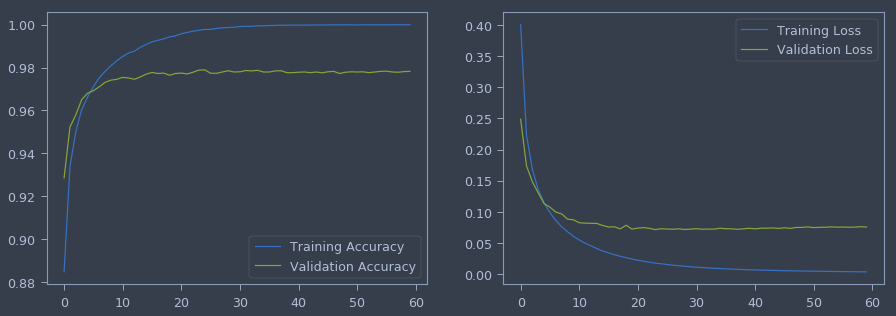

In [29]:
hist = history['Fully Connected']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

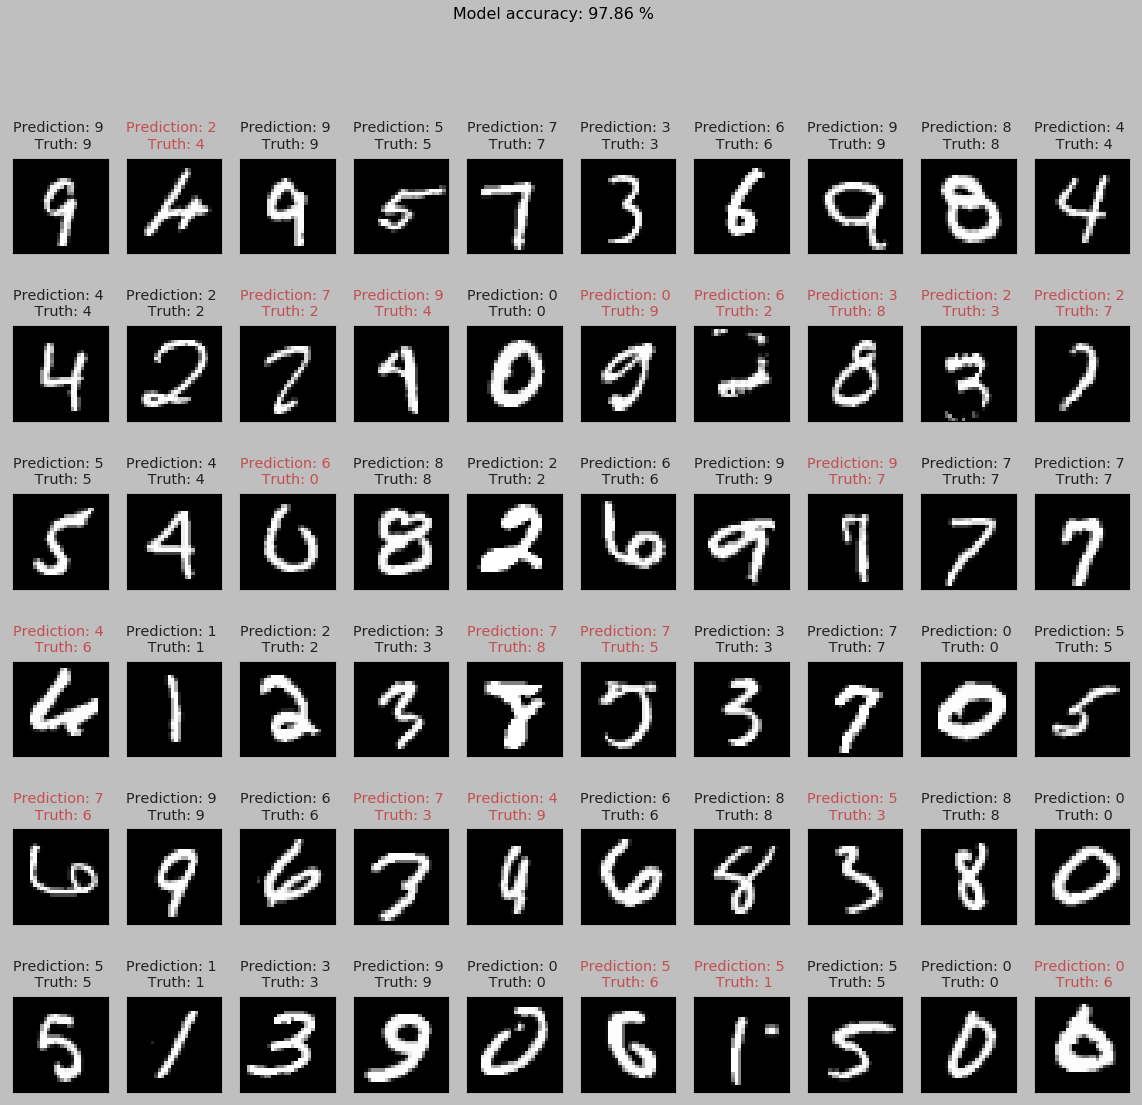

In [30]:
K.clear_session()
model = load_model(path.join('data', 'fully_connected.h5'))
show_test(model, (i_test, l_test))

In [ ]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional'] = h.history
history['Convolutional']['epoch'] = h.epoch
model.save(path.join('data', 'convolutional.h5'))

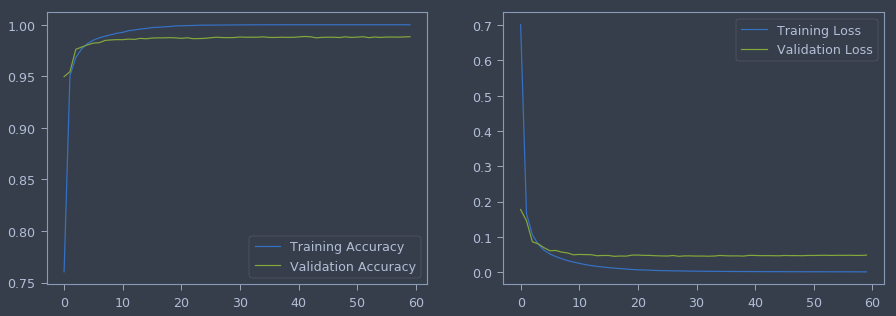

In [31]:
hist = history['Convolutional']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

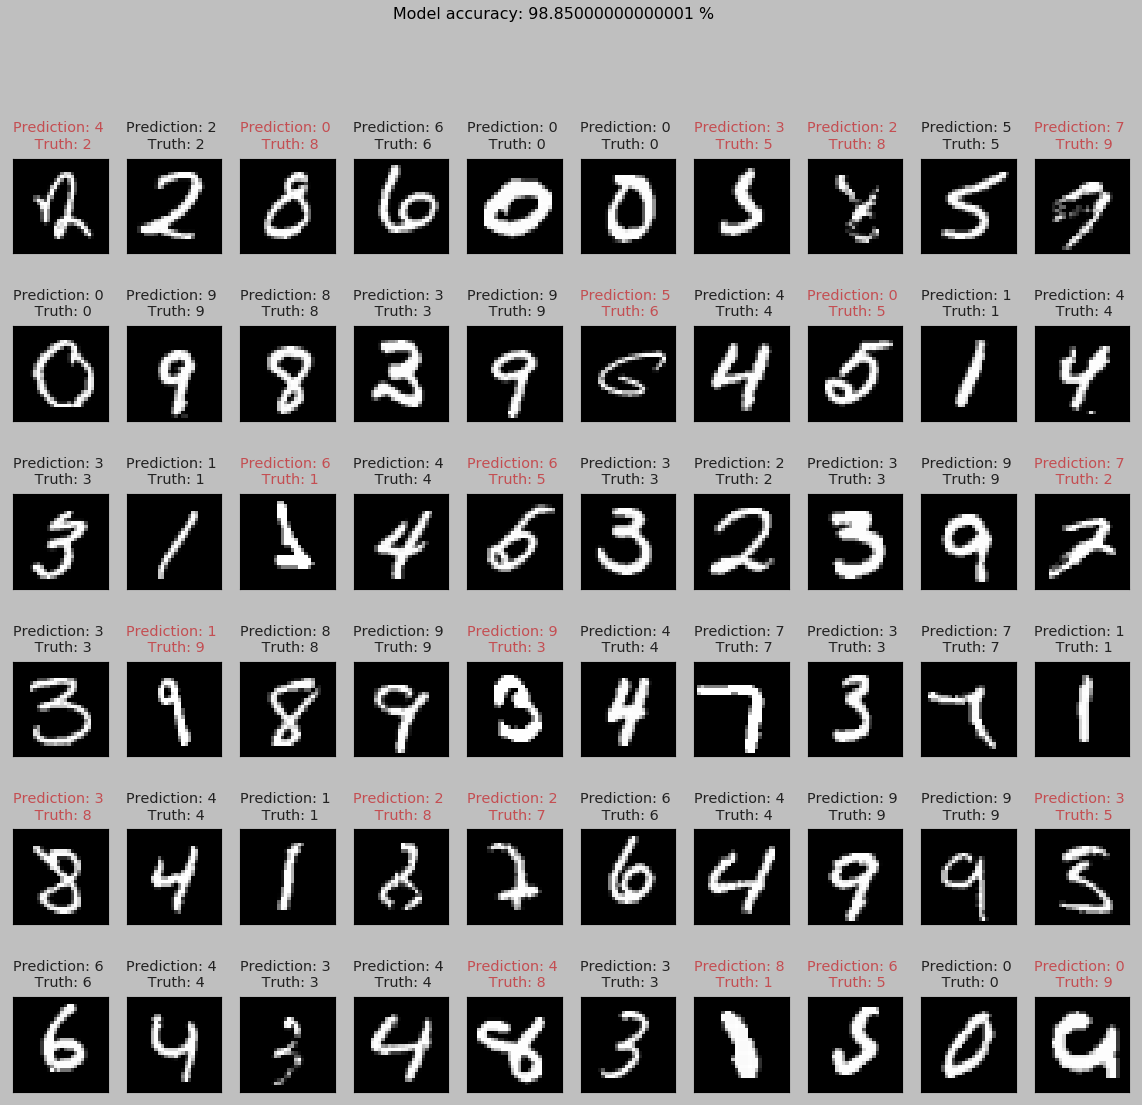

In [32]:
K.clear_session()
model = load_model(path.join('data', 'convolutional.h5'))
show_test(model, (i_test, l_test))

In [ ]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2layers'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional (2 Layers)'] = h.history
history['Convolutional (2 Layers)']['epoch'] = h.epoch
model.save(path.join('data', 'convolutional_2layers.h5'))

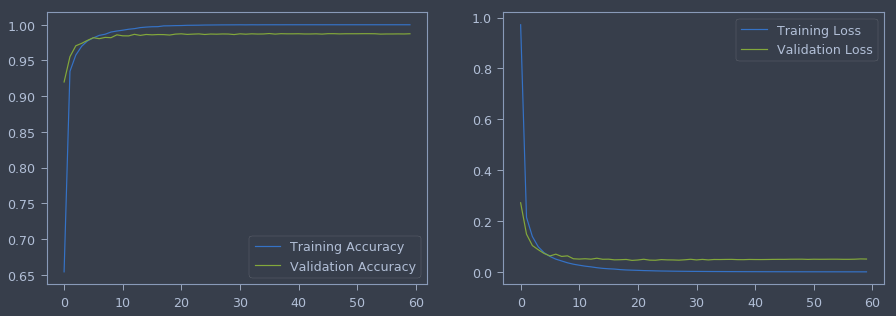

In [33]:
hist = history['Convolutional (2 Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

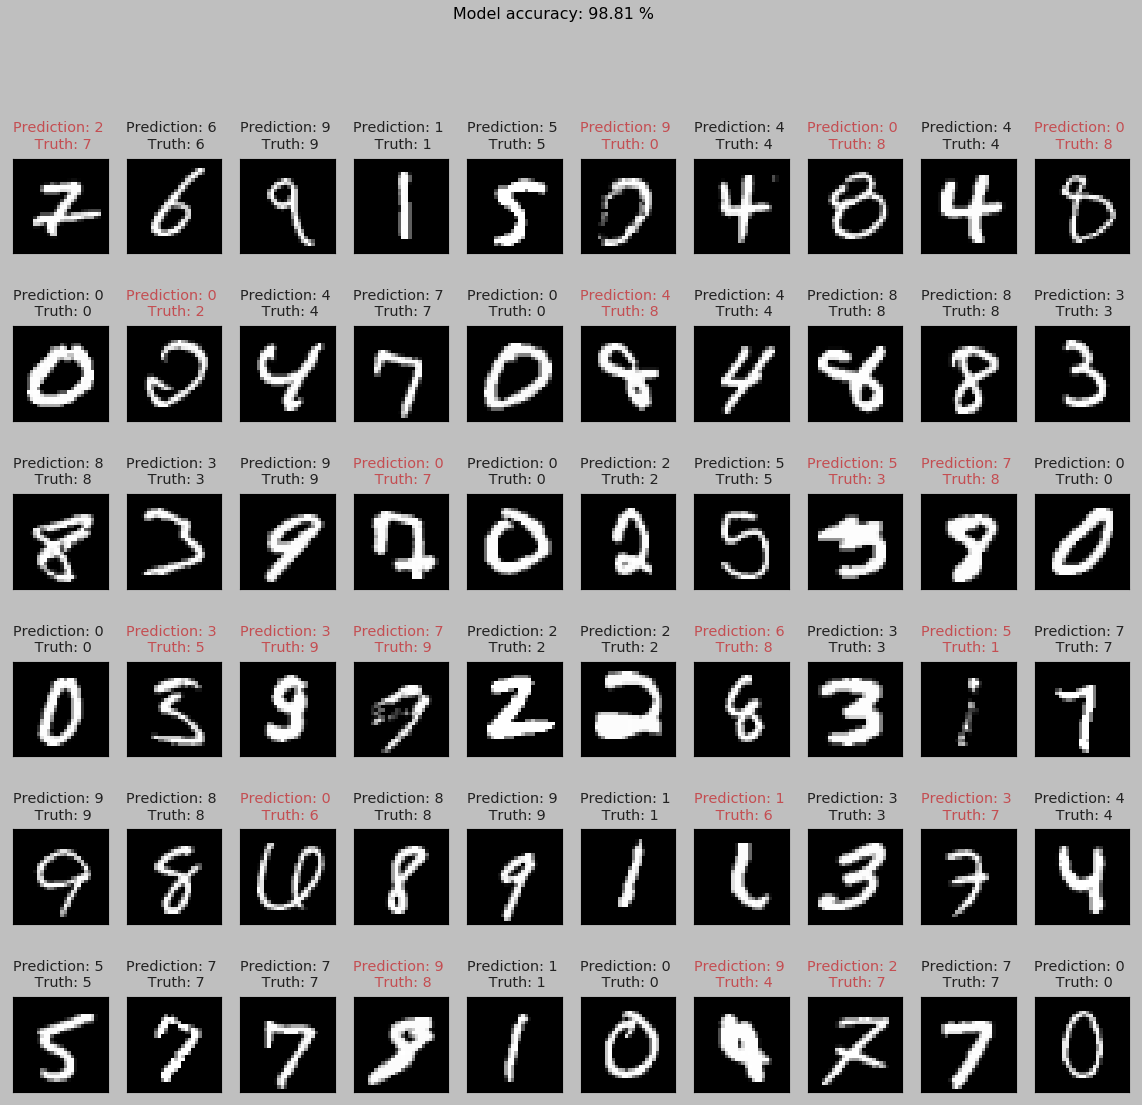

In [34]:
K.clear_session()
model = load_model(path.join('data', 'convolutional_2layers.h5'))
show_test(model, (i_test, l_test))

In [ ]:
i_enh, l_enh = enhance_mnist(i_train, l_train)

In [ ]:
activation_fcn = 'relu'
lmbd = 0.01
learn_rate = 0.03
minibatch_size = 10

In [ ]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_relu'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, verbose=True)
h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (ReLU)'] = h.history
history['Convolutional (ReLU)']['epoch'] = h.epoch
model.save(path.join('data', 'convolutional_relu.h5'))

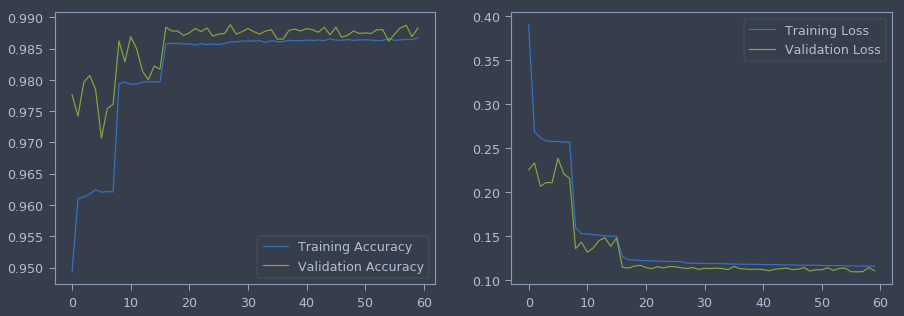

In [35]:
hist = history['Convolutional (ReLU)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

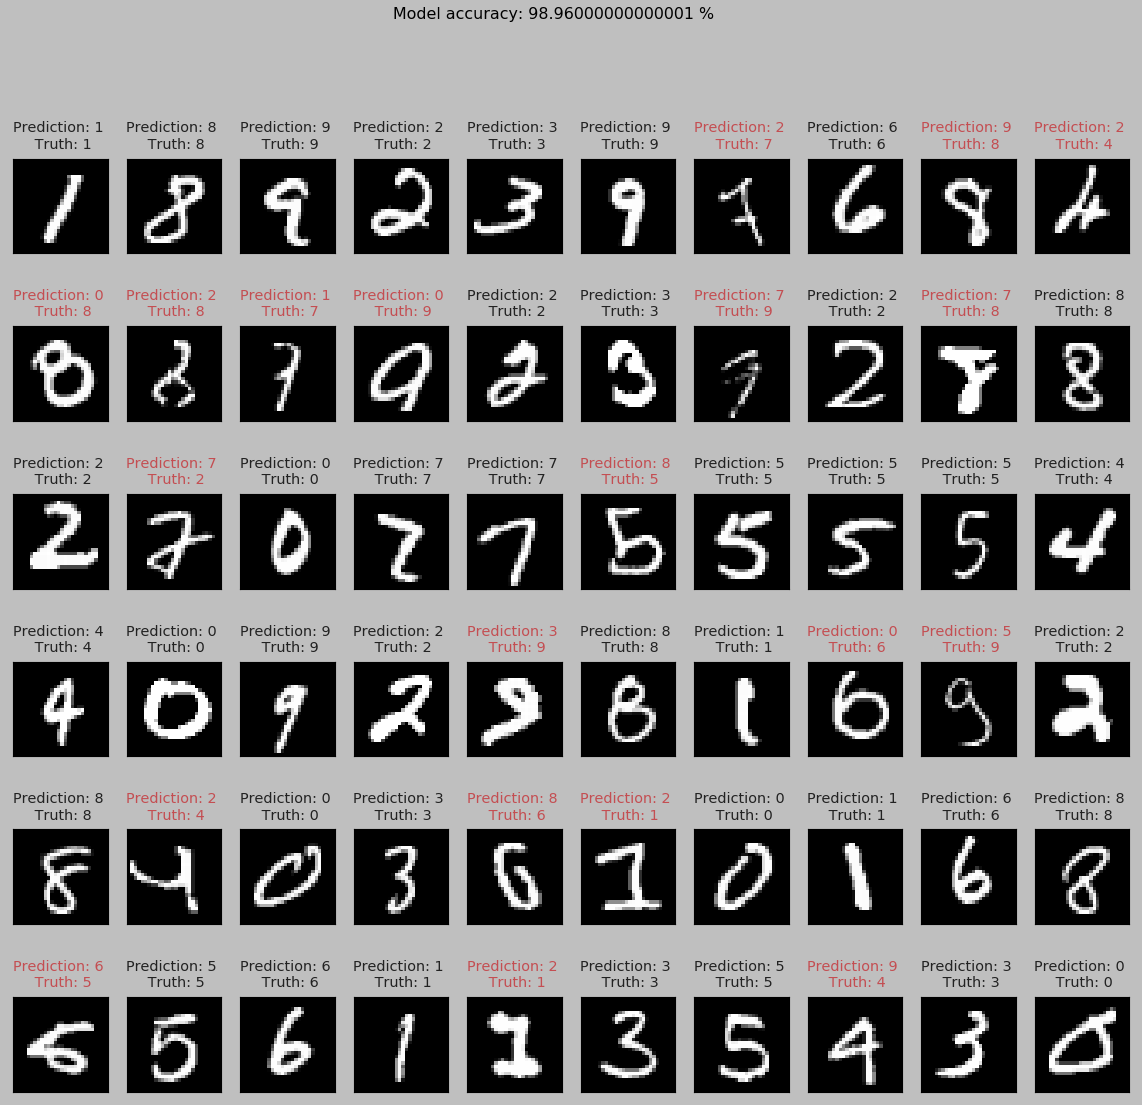

In [36]:
K.clear_session()
model = load_model(path.join('data', 'convolutional_relu.h5'))
show_test(model, (i_test, l_test))

In [ ]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2dense'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (2 Dense Layers)'] = h.history
history['Convolutional (2 Dense Layers)']['epoch'] = h.epoch
model.save(path.join('data', 'convolutional_2dense.h5'))

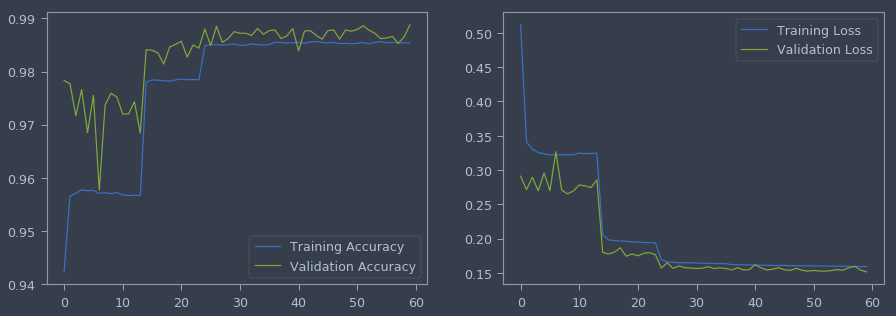

In [37]:
hist = history['Convolutional (2 Dense Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

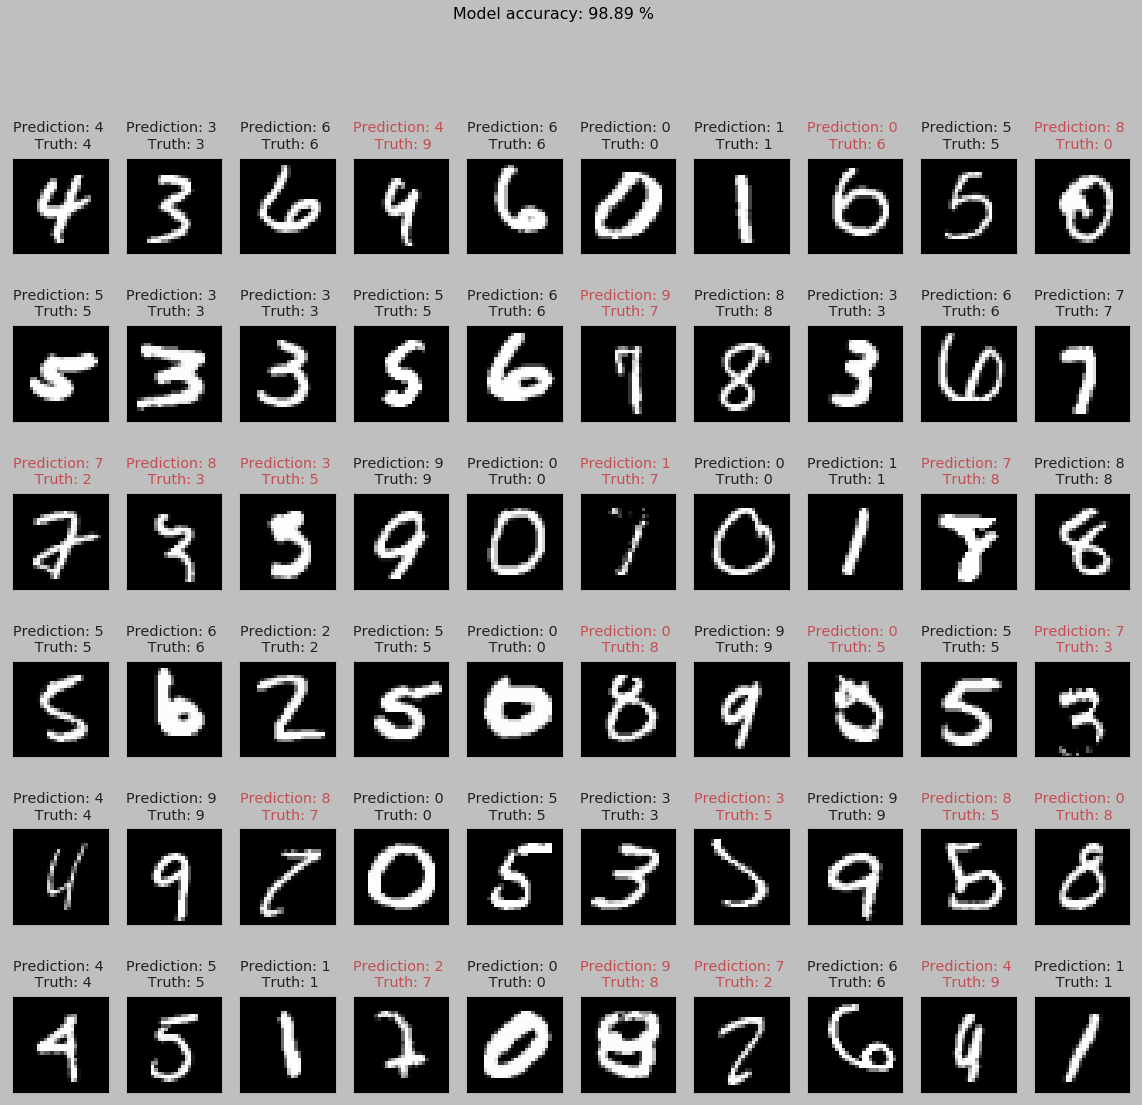

In [38]:
K.clear_session()
model = load_model(path.join('data', 'convolutional_2dense.h5'))
show_test(model, (i_test, l_test))

In [ ]:
K.clear_session()
regularization = None#regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_dropout'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (Dropout)'] = h.history
history['Convolutional (Dropout)']['epoch'] = h.epoch
model.save(path.join('data', 'convolutional_dropout.h5'))

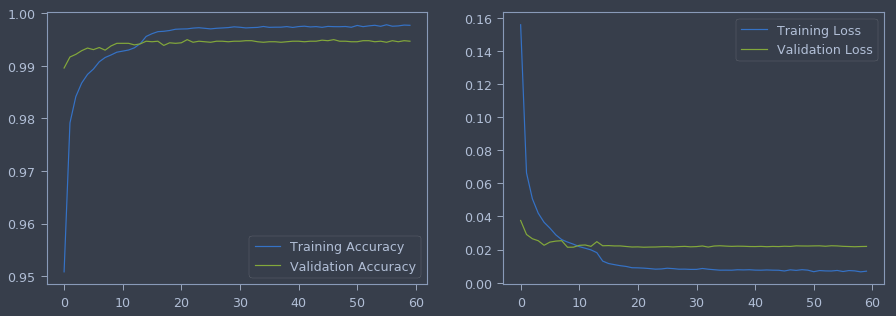

In [39]:
hist = history['Convolutional (Dropout)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

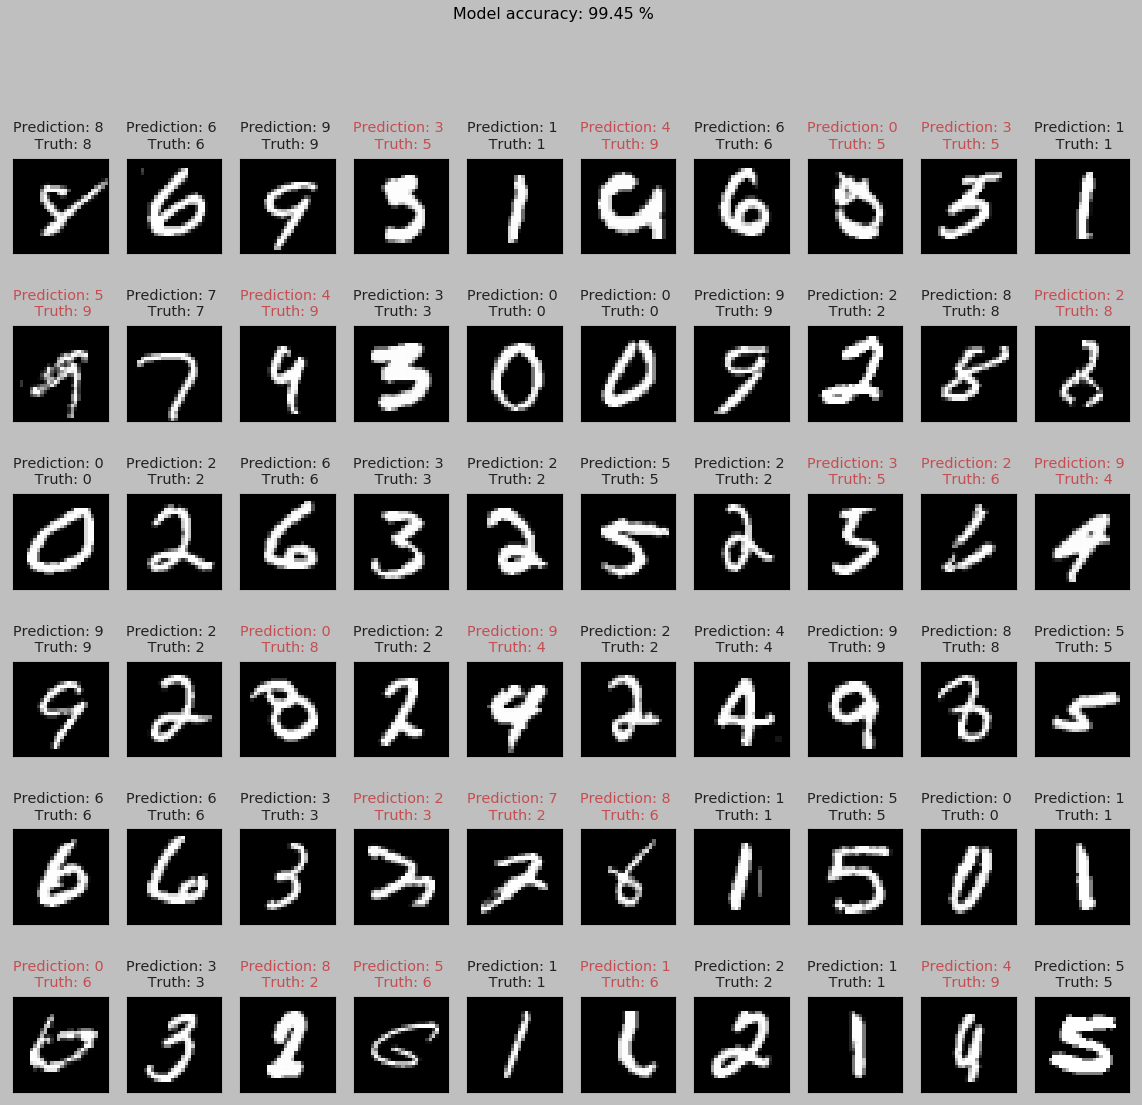

In [40]:
K.clear_session()
model = load_model(path.join('data', 'convolutional_dropout.h5'))
show_test(model, (i_test, l_test))

In [ ]:
with open(path.join('data', 'training_hist.pkl'), 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

Summary Plots
=============

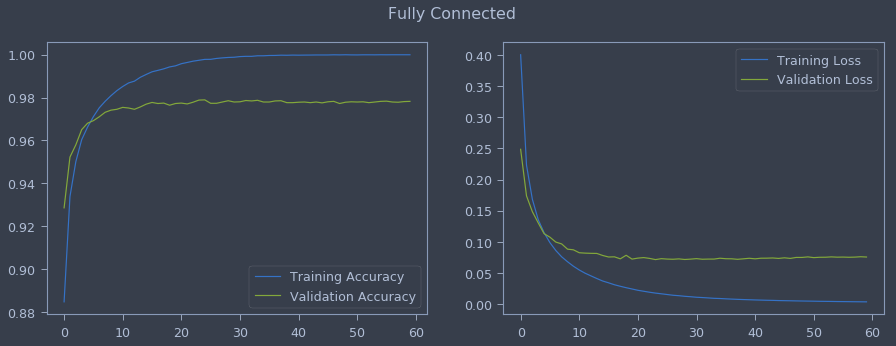

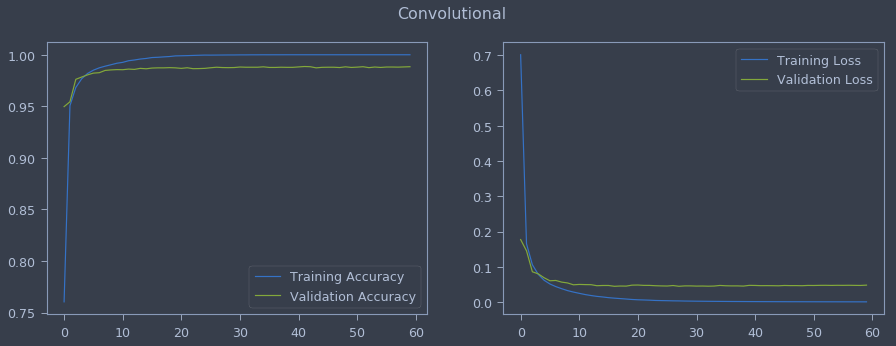

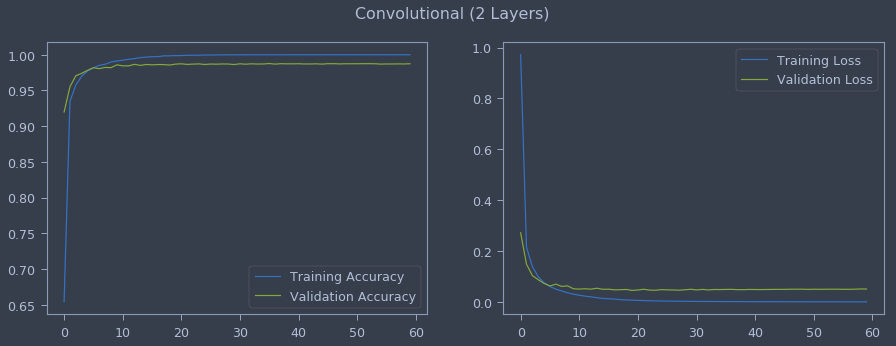

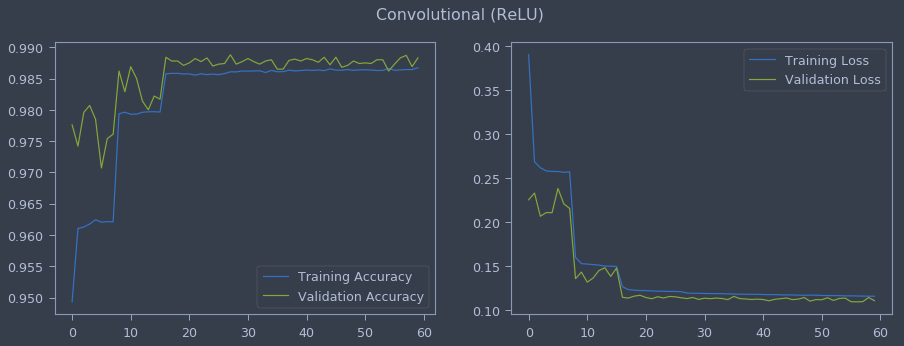

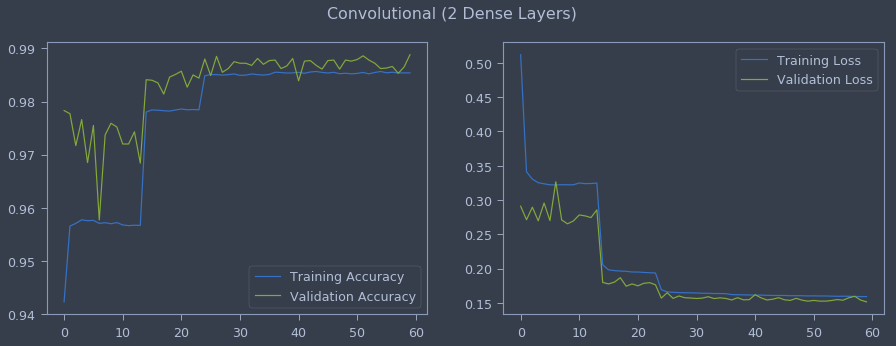

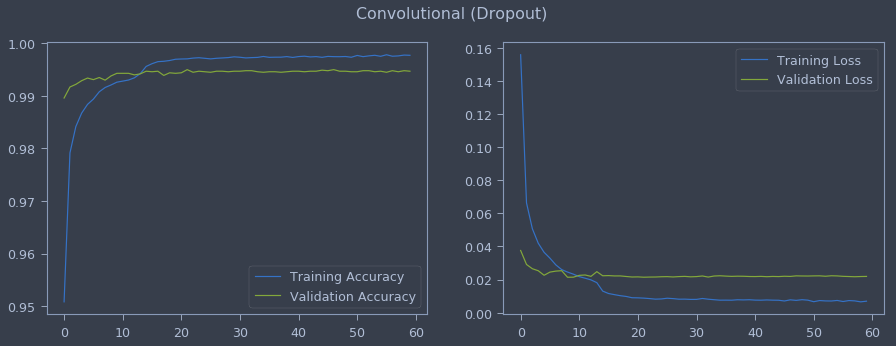

In [41]:
for name, hist in history.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(hist['epoch'], hist['acc'])
    ax[0].plot(hist['epoch'], hist['val_acc'])
    ax[0].legend(['Training Accuracy','Validation Accuracy'])
    ax[1].plot(hist['epoch'], hist['loss'])
    ax[1].plot(hist['epoch'], hist['val_loss'])
    ax[1].legend(['Training Loss','Validation Loss'])
    fig.suptitle(name)
plt.show()